In [416]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline 
from collections import Counter
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from collections import Counter
from sklearn import model_selection
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from datetime import datetime
from IPython import display
from collections import Counter
import imblearn
from imblearn.over_sampling import SMOTE
import pickle
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight

In [417]:
df = pd.read_csv('All Data_USER (2).csv')

# Project Objective

The modern enterprise requires a Change Management solution that is equipped to support any and all changes they may face. Through advanced automation and workflow, ChangeGear has been designed to streamline the entire change and release management process. Organizations are enabled to meet auditing and compliance requirements with ease. Universally, IT Service Management (ITSM) is an important corporate function responsible for leveraging innovation to increase value, maximizing user productivity, providing end-to-end tech services, and so much more.
<br><br>
Currently, **Niagara IT departments are facing the business issue** of dealing with ChangeGear Incidents that are (a) incorrectly assigned (b) out of the scope of what the corresponding team should be responsible for. **This leads to an inefficient allocation of department resources the misalignment of team goals, responsibilities, and accountability.** As a result, expectations and the execution of these teams may ultimately become skewed as perceived by end users. From working with the WMS team and leading a monthly meeting to perform descriptive analytics of tickets, there is a widespread concern surronding this dilemma. Our team faces an overwhelmingly high volume of tickets that are typically out of scope and incorrectly assigned. 
<br><br>
This opportunity proposes a potential solution for **Multi Classification via Supervised Machine Learning** to categorize support tickets based on a fixed number of business groups and department teams. We can easily scrape text and category from each ticket and train a model to associate certain words and phrases with a particular category. If incoming tickets are classified with a higher accuracy through a trained and tested model, this will lead to more team efficiency, saving a significant amount of time. Additionally, this proposed solution specifically addresses the faultiness of human error and perception: end users may not fully understand the roles and responsibilities of each IT team while IT Teams can equally contribute to this business error by accepting a mistaken ticket. **Resultantly, this leads to a cycle of poor IT Governance**.   
<br><br>
This analysis expects the following outcomes:
1. Machine learning can provide immediate cost savings and more accurate predictions than the human counterpart.
2. Better categorization of ticket assignment.
3. Understanding of the words and features as specific issues/software/problems that are correlated with each team.

# Data Information

The data extracted from ChangeGear includes the all time CLOSED ticket incidents for all Niagara plants. For descriptive analytics we would like to understand most of the data attributes such as the teams (Owner), the incident categories (Incident Type and Incident Type Full Path), and finally the opening date of the ticket (Created) which can provide a low scale time series component. However, our focus will be prioritized on the textual submission by the user (Summary).

In [418]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154657 entries, 0 to 154656
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   Item ID                  154652 non-null  object
 1   Created                  154657 non-null  object
 2   Priority                 154648 non-null  object
 3   Requester                154657 non-null  object
 4   Location Name            153507 non-null  object
 5   Owner                    153200 non-null  object
 6   Assign To                135370 non-null  object
 7   Closed Date              154657 non-null  object
 8   Close Type               153980 non-null  object
 9   Incident Type            154568 non-null  object
 10  Incident Type Full Path  154568 non-null  object
 11  Summary                  154655 non-null  object
 12  Resolution               94228 non-null   object
dtypes: object(13)
memory usage: 15.3+ MB


In [419]:
df.head()

,Item ID,Created,Priority,Requester,Location Name,Owner,Assign To,Closed Date,Close Type,Incident Type,Incident Type Full Path,Summary,Resolution
0,IR-0159611,5/19/2021,4 - Low,Colleen Davison,Plant-HOUSTON,EAM & MRO Inventory Support,Stephen Amaya,5/19/2021,All tasks completed,Location Management ?,Software:Power Pick Global ?:Location Manageme...,Red Bin Errors in PPG Loc. Mgmt,NaN
1,IR-0159604,5/19/2021,3 - Medium,Sarah Spall,Home Office-CORP-OFFSITE,IT Service Desk Team,NaN,5/19/2021,All tasks completed,Other ?,Software:Other ?,Need MSSQL Server Management Studio 18,Can download SQL on my own
2,IR-0159578,5/19/2021,4 - Low,Madeline Cannon,Home Office-CORP-OFFSITE,IT Service Desk Team,Melvin Baires,5/19/2021,User Training,Other ?,Software:Other ?,Microsoft Teams needed,Provided teams link
3,IR-0159569,5/19/2021,3 - Medium,Sy Nguyen,Corporate-CORP-MAIN,Network Team,Paul Gutierrez,5/19/2021,All tasks completed,Remote Access ?,Access/Accounts/Passwords:Access Request:VPN ?...,VPN Request for External Consultant,NaN
4,IR-0159559,5/19/2021,2 - High,Joshua Amann,Plant-STOCKTON 2,System Admin Team,NaN,5/19/2021,Duplicate Ticket,Cameras / Cisco VSOM ?,Access/Accounts/Passwords:Access Request:Camer...,Need Camera Access,Duplicate of IR-0159558


# Basic Data Preperation

## Ensure Proper Data Types

In [420]:
df['Open Date']=pd.to_datetime(df['Created'])
df['Closed Date']=pd.to_datetime(df['Closed Date'])

In [421]:
df=df.set_index('Open Date')

In [422]:
df.index

DatetimeIndex(['2021-05-19', '2021-05-19', '2021-05-19', '2021-05-19',
               '2021-05-19', '2021-05-19', '2021-05-19', '2021-05-19',
               '2021-05-19', '2021-05-19',
               ...
               '2018-01-08', '2018-01-08', '2018-01-08', '2018-01-05',
               '2018-01-05', '2018-03-14', '2018-03-14', '2018-03-14',
               '2018-03-14', '2020-06-22'],
              dtype='datetime64[ns]', name='Open Date', length=154657, freq=None)

In [423]:
df.head(1)

,Item ID,Created,Priority,Requester,Location Name,Owner,Assign To,Closed Date,Close Type,Incident Type,Incident Type Full Path,Summary,Resolution
Open Date,,,,,,,,,,,,,
2021-05-19,IR-0159611,5/19/2021,4 - Low,Colleen Davison,Plant-HOUSTON,EAM & MRO Inventory Support,Stephen Amaya,2021-05-19,All tasks completed,Location Management ?,Software:Power Pick Global ?:Location Manageme...,Red Bin Errors in PPG Loc. Mgmt,NaN


## Missing Values

In [424]:
df.isna().sum()

Item ID                        5
Created                        0
Priority                       9
Requester                      0
Location Name               1150
Owner                       1457
Assign To                  19287
Closed Date                    0
Close Type                   677
Incident Type                 89
Incident Type Full Path       89
Summary                        2
Resolution                 60429
dtype: int64

Looking at the missing values we see that the most outstanding is Resolution, Assign To, Owner, Location Name, Close Type, Incident Type and Full Path. We have to assess how to handle these missing values for each column. 
<br> 
1. **Resolution**: The resolution is not that important and will not be that impactful on our analysis. However, the analyses of the resolution for each type of incident can prove beneficial in a potential future study. We can simply delete this column from our dataset for this study.
2. **Assign To**: This is the employee who was assigned to the corresponding ticket. We can delete this column from our dataset for this study.
3. **Owner**: This is the department/team for which the incident was assigned to. Since this is our main classifier, we need all records to have this label. We will drop all records that have a missing value here.
4. **Location Name**: This is the plant from which the ticket originated from. We will proceed to keep this column, however we will remove all records that have a missing value here. 
4. **Close Type**: This specifies the reason why the incident was closed, however we will remove all records that have a missing value here for consistency.
5. **Incident Type/Full Path**: This categorizes the incident of the ticket. This will be important for our analysis so we will remove all records that have a missing value here.

In [425]:
#Drop Not Need Columns
del df['Resolution']
del df['Assign To']

#Drop NA records for columns
na_columns = ['Owner', 'Location Name', 'Close Type', 'Incident Type', 'Incident Type Full Path']
for column in na_columns:
    df = df[df[column].notna()]

In [426]:
#Double Check for NA values
df.isna().sum()

Item ID                    0
Created                    0
Priority                   0
Requester                  0
Location Name              0
Owner                      0
Closed Date                0
Close Type                 0
Incident Type              0
Incident Type Full Path    0
Summary                    0
dtype: int64

In [427]:
#See count of all reasons why Ticket Submission was closed
df.groupby('Close Type')['Item ID'].nunique().sort_values(ascending=False)

Close Type
All tasks completed                              112993
No Action Required                                11667
Account Maintenance                                8401
No response from user                              4684
Equipment Replaced/Upgraded/Returned/Repaired      3208
Software Maintenance                               2137
User Training                                      1789
Application Maintenance                            1741
Duplicate Ticket                                   1625
Known Error                                        1416
Out of Scope                                       1025
Network Outage                                      609
Service Request                                     293
Future Enhancement                                  251
Name: Item ID, dtype: int64

The results above are very useful for cleaning our data and working toward removing data that would cause detriment to our model results. In this case, Close Type can be quite indicative of bad data. This would be because varying reasons as to why the ticket was closed could mean different things, not necessarily that the ticket was appropriately resolved. Other reasons could be that it was closed because it was Out of Scope or the submission of the ticket was an admitted mistake from the requestor. In those two examples, including such labeled data would later cause inaccurate predictions due to training our model with incorrect data. We will filter out these Close Type incidents from out dataset. 

In [428]:
#We will filter out 'Duplicate Ticket' and 'Out of Scope'
df=df[df['Close Type'] != 'Duplicate Ticket']
df=df[df['Close Type'] != 'Out of Scope']

# Advanced Data Preparation
## Regex

In [429]:
#dataframe of corpus and classifier
corpusAndClassifier_df = df[['Owner','Summary']]

In [430]:
corpusAndClassifier_df.head()

,Owner,Summary
Open Date,,
2021-05-19,EAM & MRO Inventory Support,Red Bin Errors in PPG Loc. Mgmt
2021-05-19,IT Service Desk Team,Need MSSQL Server Management Studio 18
2021-05-19,IT Service Desk Team,Microsoft Teams needed
2021-05-19,Network Team,VPN Request for External Consultant
2021-05-19,IT Service Desk Team,REQUEST ORACLE PASSWORD RESET FOR GLEN MURPHY ...


In [431]:
wpt=nltk.WordPunctTokenizer()
stop_words=nltk.corpus.stopwords.words('english')
porter=PorterStemmer()

In [432]:
#create text preprocessing pipeline
def normalize_doc(doc):
    doc=re.sub(r'[^a-zA-Z\s]', '', doc) #eliminate special characters 
    doc=doc.lower() #change all to lowercase
    doc=doc.strip() #remove whitespace
    tokens=wpt.tokenize(doc)
    filtered_tokens=[token for token in tokens if token not in stop_words]
    doc=' '.join(filtered_tokens)
    return doc

### Normalize Summary

In [433]:
text=corpusAndClassifier_df['Summary'] 
normalize_corpus=np.vectorize(normalize_doc) #create a vectorized object for our normalization pipeline
norm_corpus=normalize_corpus(text)
corpusAndClassifier_df['Clean_Summary']=norm_corpus

<ipython-input-433-a2bd9d6db9d3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpusAndClassifier_df['Clean_Summary']=norm_corpus


In [434]:
corpusAndClassifier_df.head(10)

,Owner,Summary,Clean_Summary
Open Date,,,
2021-05-19,EAM & MRO Inventory Support,Red Bin Errors in PPG Loc. Mgmt,red bin errors ppg loc mgmt
2021-05-19,IT Service Desk Team,Need MSSQL Server Management Studio 18,need mssql server management studio
2021-05-19,IT Service Desk Team,Microsoft Teams needed,microsoft teams needed
2021-05-19,Network Team,VPN Request for External Consultant,vpn request external consultant
2021-05-19,IT Service Desk Team,REQUEST ORACLE PASSWORD RESET FOR GLEN MURPHY ...,request oracle password reset glen murphy empl...
2021-05-19,Network Team,DEN - CHECKIN LANE 2 - EX 0652 IS DOWN,den checkin lane ex
2021-05-19,IT Service Desk Team,Oracle Access,oracle access
2021-05-19,HRIS Team,Two people hired to R22289,two people hired r
2021-05-19,EAM & MRO Inventory Support,Request to make a change on PO# 673525. I've a...,request make change po ive attached po invoice...


In the above code, we have prepared our textual data for further analysis and experimentation for modeling. PorterStemmer is used to optimize our results by extracting the base form of the words through the removal of affixes from. For example, the stem of the words eating, eats, eaten is eat. Search engines use stemming for indexing the words. 

# EDA and Descriptive Analytics

The focus of exploring our data will be on gaining insight into the categories and the departments that see a volume of tickets. This will aid our study by clarifying the best routes of action to take for further analysis. Provided are a number of topics to address here:
1. Busiest Departments and Teams
2. The Top Issues
3. Incidents Over Time
4. Ticket Volume Over Time for heavy teams

In [440]:
df.index.min(), df.index.max()

(Timestamp('2018-01-05 00:00:00'), Timestamp('2021-05-19 00:00:00'))

Open Date
2018-01-31     850
2018-02-28    2220
2018-03-31    2478
2018-04-30    2726
2018-05-31    2696
2018-06-30    2894
2018-07-31    2827
2018-08-31    2889
2018-09-30    2707
2018-10-31    3117
2018-11-30    2872
2018-12-31    3211
2019-01-31    4445
2019-02-28    4082
2019-03-31    4341
2019-04-30    4655
2019-05-31    5202
2019-06-30    4697
2019-07-31    4775
2019-08-31    4367
2019-09-30    4105
2019-10-31    4564
2019-11-30    3556
2019-12-31    3346
2020-01-31    4438
2020-02-29    4538
2020-03-31    5125
2020-04-30    4919
2020-05-31    4329
2020-06-30    4873
2020-07-31    3922
2020-08-31    3554
2020-09-30    3522
2020-10-31    3737
2020-11-30    3403
2020-12-31    3735
2021-01-31    3665
2021-02-28    3314
2021-03-31    3613
2021-04-30    3377
2021-05-31    1503
Freq: M, Name: Created, dtype: int64


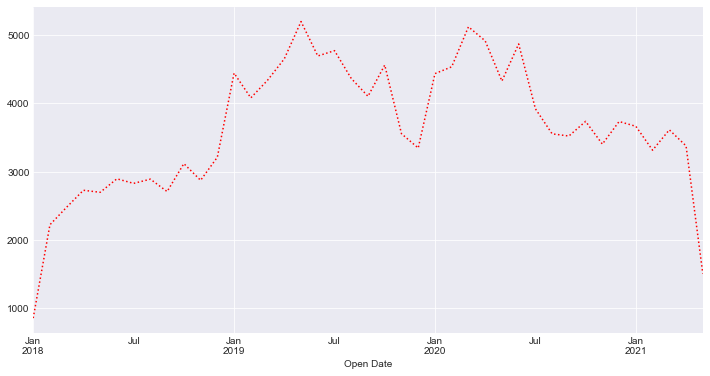

In [448]:
#Time Resampling for Tickets
ticketTimeSeries=df['Created'].resample(rule = 'M').count()
print(ticketTimeSeries)
df['Created'].resample(rule = 'M').count().plot.line(figsize=(12,6), 
                                                         linestyle='dotted', 
                                                         color='red') #aggregation of month end frequency for ticketsmb
plt.savefig('timeseries.png')

We see the volumne of tickets throughout the starting point in January until March. 

### Niagara IT Teams

In the following visualizations, we will look at our model class: the Niagara teams for all tickets. From this analysis, we will be able to decide if we would need to pivot our data in a certain direction, i.e. to either focus on a few teams or all.

In [438]:
len(pd.unique(df['Owner']))

124

In the data, there are 124 distinct values for Owner. This number is very high. A high number of classes in a multiclassification problem is problematic for accuracy. Why? **When a dataset do not represent all classes of data equally, the model might overfit to the class that’s represented more in the dataset and become oblivious to the existence of the minority class. Though it could result in a good accuracy, it may fail miserably in production.**. To better validate this, we look at the distribution of the data.

In [439]:
#unique values in the column with value count, get lowest count
ownerUniqueCounts=df['Owner'].value_counts(ascending=True)
ownerUniqueCounts.iloc[:50]

Elias Lopez_00                            1
Maintenance Compliance Team               1
Paul Gutierrez                            1
Yevette Baker_00_00                       1
Alain Cholette                            1
Ruben Armas                               1
Marisol Castrejon                         1
Paul Gonzalez                             1
Fernando Diaz                             1
Central Logistic Ops Superusers           1
Jack Kaylor                               1
EAM Warranty Team                         1
Meal Expense Team                         1
Janelle Roper                             1
Trevor Deight                             1
Strategic Planning Department             1
Wilson Shiao                              1
Gus Larios                                1
Central Customer Service Superusers       1
Sheau-Ling Kostlan_00                     1
3PL Team                                  2
Fitzpatrick                               2
EBS Approvals Team - Indirect Bu

This shows that our classes are poorly balanced. This imbalance would negatively impact the accuracy of our model so this presents the need to further clean the classes. 

Text(0, 0.5, 'Count of Incidents')

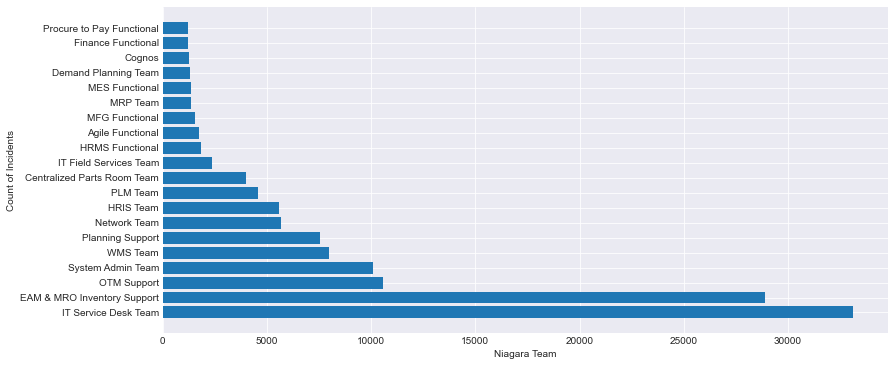

In [449]:
#Busiest Departments and Teams: Top 10
departments = df['Owner'].value_counts().head(20)
plt.style.use('seaborn-darkgrid')
y1=departments.values
x1=departments.index
plt.figure(figsize=(13,6))
plt.barh(x1,y1)
plt.xlabel('Niagara Team')
plt.ylabel('Count of Incidents')

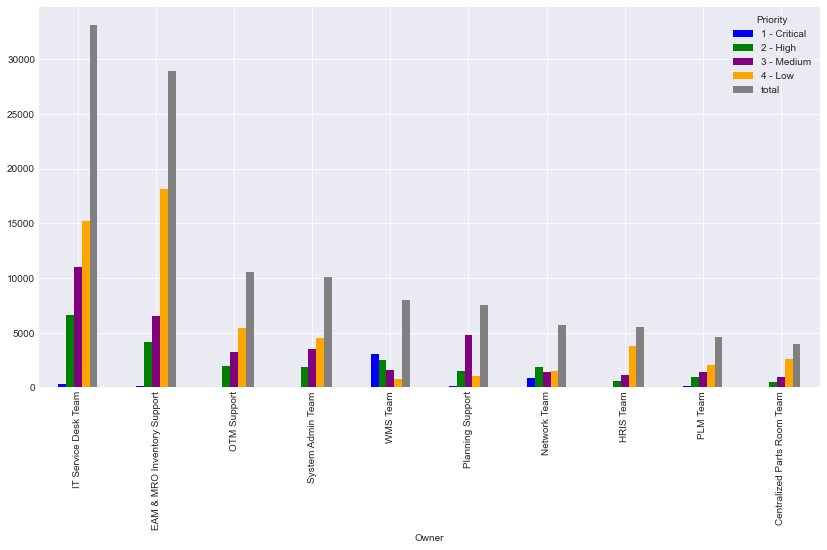

In [447]:
#Departments and Ticket Types
cross_tab1 = pd.crosstab(df.Owner, df.Priority)
cross_tab1['total'] = cross_tab1['1 - Critical'] + cross_tab1['2 - High'] + cross_tab1['3 - Medium'] + cross_tab1['4 - Low']
cross_tab1.sort_values(by='total', ascending=False).head(10).plot(kind='bar',
                                                                 figsize=(14,7), 
                                                                 color=['blue', 'green', 'purple','orange', 'gray'])
plt.savefig('changegear_teams.png')

Acknowledging the graphic and the sum above, we can see that we have a large number of data to work with if we focus on the more relevant and most heavy hitting departments. IT Service Desk Team obviously faces the largest number of ticket volume, and the volumne significantly starts to drop off afterward. We can focus on our analysis on this number of teams as they have the most tickets. Even with the Top 20 Owners, there is still a significant imbalance between the classes. Later in this analysis, we will explore oversampling/undersampling. 
<br><br>
For now, let's only focus on teams where they have at least closed 5000 tickets all time.

In [28]:
topTeams = ownerUniqueCounts[ownerUniqueCounts >= 5000]
topTeams=topTeams.index.tolist()

In [29]:
topTeams

['HRIS Team',
 'Network Team',
 'Planning Support',
 'WMS Team',
 'System Admin Team',
 'OTM Support',
 'EAM & MRO Inventory Support',
 'IT Service Desk Team']

In [30]:
#filter our normalized df to only the topTeams
corpusAndClassifier_df=corpusAndClassifier_df[corpusAndClassifier_df['Owner'].isin(topTeams)]

### Incidents

Text(0, 0.5, 'Count of Incidents')

C:\Users\jlinao\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jlinao\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0, flags=flags)


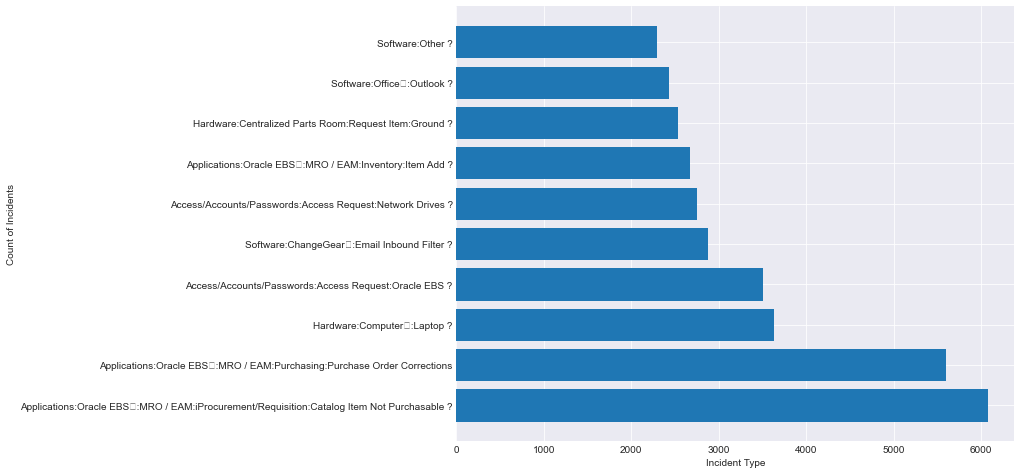

In [31]:
#Most Common Incidents
incidentType = df['Incident Type Full Path'].value_counts().head(10)
y2=incidentType.values
x2=incidentType.index
plt.figure(figsize=(10,8))
plt.barh(x2,y2)
plt.xlabel('Incident Type')
plt.ylabel('Count of Incidents')

Taking a quick look at the most common incident type full paths, we see that Applications are the obvious heavy hitter when it comes to a single topic that Niagara end users see issues with. An interesting takeaway from these results is that the two most common incidents are also the most specific Incident Type Full Paths. 

### Priority Level

Text(0, 0.5, 'Count')

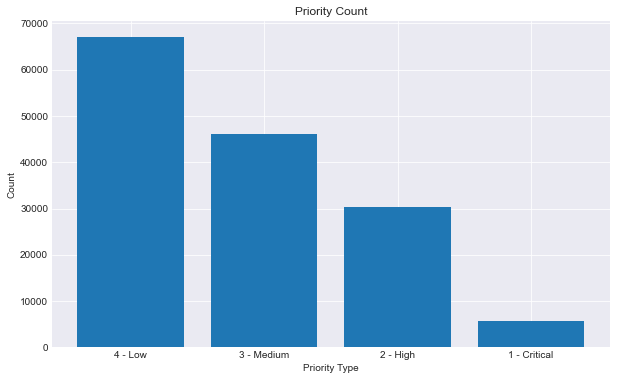

In [32]:
priorityLevel=df['Priority'].value_counts()
y3=priorityLevel.values
x3=priorityLevel.index
plt.figure(figsize=(10,6))
plt.bar(x3,y3)
plt.title('Priority Count')
plt.xlabel('Priority Type')
plt.ylabel('Count')

We see that there is an inverse linear relationship between the priority level of the ticket and the volume of the ticket.  

# Data Modeling

With our business problem being a multiclass classification problem, we have many models to fit to our data and make predictions. The only way to find the most appropriate one, is to train, test, and evaluate all of them. To carry this out, we will utilize a pipeline for each classifier. After evaluating and selecting said model, we will then run a grid seach in order to find the optimal hyperparameters of the model which results in the most ‘accurate’ predictions. 
<br>
We will look at the following models with a short overview of each: 
* **Logistic Regression**: In statistics, the logistic model is used to model the probability of a certain class or event existing such as pass/fail, win/lose, alive/dead or healthy/sick. This can be extended to model several classes of events such as determining whether an image contains a cat, dog, lion, etc.
* **Classification and Regression Trees**: (CART) is a predictive model, which explains how an outcome variable's values can be predicted based on other values. A CART output is a decision tree where each fork is a split in a predictor variable and each end node contains a prediction for the outcome variable.
* **K-Nearest Neighbors**:KNN algorithms use data and classify new data points based on similarity measures (e.g. distance function). Classification is done by a majority vote to its neighbors. The data is assigned to the class which has the nearest neighbors. As you increase the number of nearest neighbors, the value of k, accuracy might increase.
* **Gradient Boosted Trees**: (GBT) Gradient boosting  produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. When a decision tree is the weak learner, the resulting algorithm is called gradient boosted trees, which usually outperforms random forest. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.
<br>
<br>
For the process of building out our selected model, we want to cover the following areas:
<br>
1. **Feature Selection**: This is incorporated in our modeling as one of the parameters that we must evaluate for the value that results in the highest accuracy. Features allow us to build a vocabulary that only consider the top max_features ordered by term frequency across the corpus. Another facet of feature selection is understanding what % of words to exclude. Excluding words based on how much and how little their frequency is is beneficial for the model. It helps consider both the insignificance of words, allowing the model to focus on more important ones. Finally it also helps negate words that are so overwhemingly frequent to the extent of providing little to no value. For feature selection, we will perform a training evaluation using different arguments for this parameter.
2. **BOW and TFIDF**: Because we are dealing with textual data and performing an NLP task, we have to implement a TFIDF transformer on our Summary data. TF-IDF is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents. By vectorizing the documents we can further perform multiple tasks such as finding the relevant documents, ranking, clustering and so on. TFIDF is proved to be more efficient and have much better results as opposed to Bag of Words (BOW) and Term Frequency (TF). 

In [33]:
#isolate our data: the classifier (Summary) and the textual data (Clean_Summary)
X=corpusAndClassifier_df['Clean_Summary'].values
y=corpusAndClassifier_df['Owner'].values

In [34]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [35]:
len(X), len(y)

(109470, 109470)

In [36]:
X.shape, y.shape

((109470,), (109470,))

In [37]:
with open ('X.pickle','wb') as f:#wb, write-byte
    pickle.dump (X,f)
    
with open ('y.pickle','wb') as f:#wb, write-byte
    pickle.dump (y,f)

## Resampling Data

A widely adopted technique for dealing with unbalanced datasets is called resampling. Resampling is done after the data is split into training, test and validation sets. Resampling is done only on the training set otherwise the performance measures could get skewed. Resampling can be of two types: **Over-sampling** and **Under-sampling**.
* Under sampling involves removing samples from the majority class. In under-sampling, the simplest technique involves removing random records from the majority class, which can cause loss of information.
* Over sampling involves adding more examples from the minority class . The simplest implementation of over-sampling is to duplicate random records from the minority class, which can cause overfitting. Another technique is synthesizing new examples of the minority class. The most widely used approach to synthesizing new examples is called the 
<br><br>
For our study, we will utilize a combination of undersampling and oversampling. 

In [38]:
#label and encode the target varibale
y = LabelEncoder().fit_transform(y)
#Summarize the distribution of target variable
counter = Counter(y)
for key, value in counter.items():
    per = value / len(y) * 100 
    print('Class=%d, n=%d (%.3f%%)' % (key, value, per))
print('\n')
print('Before Under/Over Sampling: ' + str(Counter(y)))

Class=0, n=28908 (26.407%)
Class=2, n=33134 (30.268%)
Class=3, n=5669 (5.179%)
Class=1, n=5564 (5.083%)
Class=6, n=10074 (9.203%)
Class=7, n=7989 (7.298%)
Class=5, n=7544 (6.891%)
Class=4, n=10588 (9.672%)


Before Under/Over Sampling: Counter({2: 33134, 0: 28908, 4: 10588, 6: 10074, 7: 7989, 5: 7544, 3: 5669, 1: 5564})


Text(0, 0.5, 'Count')

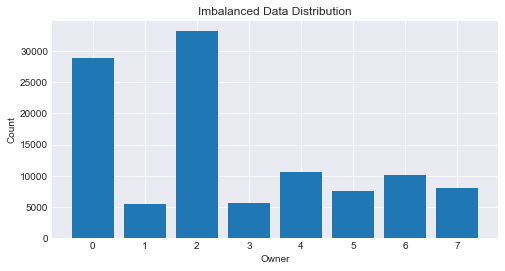

In [39]:
beforeSmplg = {}
for key, value in Counter(y).items():
    beforeSmplg[key] = value

    
category, count = zip(*beforeSmplg.items())
plt.figure(figsize=(8,4))
plt.bar(category, count)
plt.title('Imbalanced Data Distribution')
plt.xlabel('Owner')
plt.ylabel('Count')

* Class 0: EAM & MRO Inventory Support
* Class 1: HRIS Team                
* Class 2: IT Service Desk Team 
* Class 3: Network Team
* Class 4: OTM Support
* Class 5: Planning Support
* Class 6: System Admin Team
* Class 7: WMS Team
<br><br>
We see the exact distribution of Owner. This provides a clearer idea of how we should work on balancing our target variable. Of course majority class is Class 2. 

### Sampling Strategy

In [40]:
#define undersampling
sampling_strategy_under = {2: 25000, 0:15000}
#define oversampling
sampling_strategy_over = {4: 12000, 6:12000, 7:10000, 5: 10000, 3:8500, 1:8500}

over = RandomOverSampler(sampling_strategy=sampling_strategy_over)
under = RandomUnderSampler(sampling_strategy=sampling_strategy_under)

X = X.reshape(-1, 1)

In [41]:
#Undersampling
X_under, y_over = under.fit_resample(X, y)

#Oversampling
X_final, y_final = over.fit_resample(X_under, y_over)

In [42]:
#label and encode the target varibale
y_final = LabelEncoder().fit_transform(y_final)
#Summarize the distribution of target variable
counter = Counter(y_final)
for key, value in counter.items():
    per = value / len(y_final) * 100 
    print('Class=%d, n=%d (%.3f%%)' % (key, value, per))
print('\n')
print('After Under/Over Sampling: ' + str(Counter(y_final)))

Class=0, n=15000 (14.851%)
Class=1, n=8500 (8.416%)
Class=2, n=25000 (24.752%)
Class=3, n=8500 (8.416%)
Class=4, n=12000 (11.881%)
Class=5, n=10000 (9.901%)
Class=6, n=12000 (11.881%)
Class=7, n=10000 (9.901%)


After Under/Over Sampling: Counter({2: 25000, 0: 15000, 4: 12000, 6: 12000, 5: 10000, 7: 10000, 1: 8500, 3: 8500})


Text(0, 0.5, 'Count')

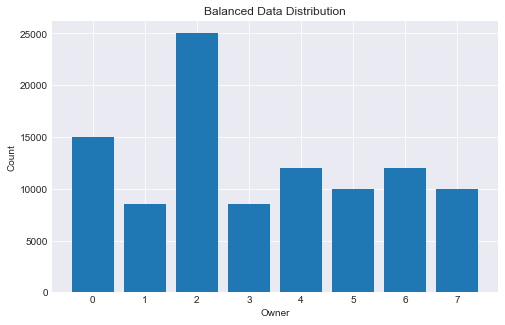

In [43]:
afterSmplg = {}
for key, value in Counter(y_final).items():
    afterSmplg[key] = value

category, count = zip(*afterSmplg.items())
plt.figure(figsize=(8,5))
plt.bar(category, count)
plt.title('Balanced Data Distribution')
plt.xlabel('Owner')
plt.ylabel('Count')

As we can see from our resampling combination of undersampling and oversampling, the classes for Owner are much more even, which will aid us in our modeling.

## Model Selection 

In [44]:
#reshape array in order to use 
X_final = X_final.ravel()

In [45]:
#split data into train, valid sets
train_X, valid_X, train_y, valid_y= train_test_split(X_final, y_final, random_state = 42, test_size=0.2)

In [46]:
stop_words=nltk.corpus.stopwords.words('english')

LR: 0.879604 (0.001785)
KNN: 0.781455 (0.002428)
CART: 0.858931 (0.001999)
GBT: 0.793822 (0.002825)


Text(0.5, 1.0, 'Model Evaluation')

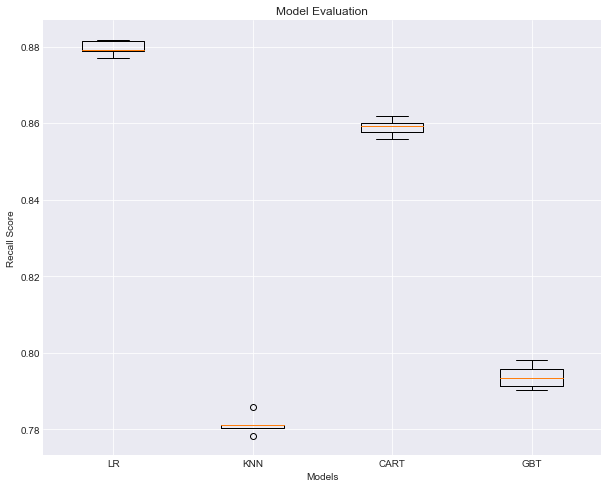

In [47]:
#append the models we are evaluating with no parameters for base performance
models = []
models.append(('LR', LogisticRegression(max_iter=1000,solver='liblinear')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('GBT', GradientBoostingClassifier()))

results = []
names = []
scoring = 'recall_weighted'

#text vectorizer and transformation
ctv = CountVectorizer(max_features=12500, max_df=0.85, stop_words=stopwords.words('english'), ngram_range=(1,2))
tfidf = TfidfTransformer()

#run cross evaluation for each model using kfold
for name, model in models:
    checker_pipeline = make_pipeline(ctv, tfidf, model)
    
    kfold = model_selection.KFold(n_splits=5, random_state=42, shuffle=True)
    cv_results = model_selection.cross_val_score(checker_pipeline, X_final, y_final, cv=kfold, scoring=scoring)
    results.append(cv_results) #add results to list which will be displayed for each model
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()) #format message
    print(msg)


plt.figure(figsize=(10, 8))
plt.boxplot(results)
plt.xlabel('Models')
plt.ylabel('Recall Score')
labels = names
labels_num = [1,2,3, 4]
plt.xticks(labels_num, labels)
plt.title('Model Evaluation')

Our model evaluation results indicate that logistic regression is the highest base performing algorithm with Classification Regression Trees not too far behind. We will choose Logisitc Regression for further analysis. In the following cells before actual implementation, we will work to tune the parameters for Logistic Regression in order to optimize its performance. The score for recall is already relatively high, which makes our predictive modeling for multiclass classification very promising.

## Logistic Regression Evaluation

In [81]:
#evaluate logistic regression to see confusion matrix
logreg = Pipeline([('vect', CountVectorizer(max_features=12500, 
                                            stop_words=stopwords.words('english'), ngram_range=(1,2))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(max_iter=1000, class_weight='balanced')),
               ])
logreg.fit(train_X, train_y)
pred_y = logreg.predict(valid_X)
print(classification_report(valid_y, pred_y))
cm=confusion_matrix(valid_y, pred_y)

rc_micro = (recall_score(valid_y, pred_y, average="micro"))
print('Micro Average Recall Score: {0:.3g}'.format(rc_micro))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      3015
           1       0.89      0.97      0.93      1696
           2       0.88      0.73      0.80      5047
           3       0.78      0.90      0.84      1763
           4       0.92      0.94      0.93      2336
           5       0.96      0.96      0.96      1995
           6       0.76      0.86      0.81      2394
           7       0.83      0.87      0.85      1954

    accuracy                           0.87     20200
   macro avg       0.87      0.90      0.88     20200
weighted avg       0.88      0.87      0.87     20200

Micro Average Recall Score: 0.875


Looking at the micro average recall score for our modeling, .88 is very good. We use micro average because it will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, micro-average is preferable in a class imbalance problem. The only concern we have suprisingly is the lowest score for the majority class for IT Service Desk Team. We will try to optimize our score by conducting grid search. 

## Grid Search

### Text Vectorizer Grid Search

In [107]:
text_vect = Pipeline([('vect', CountVectorizer(max_features=6500, 
                                            stop_words=stopwords.words('english'), ngram_range=(1,2))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(max_iter=1000, class_weight='balanced')),
               ])
print(text_vect.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'vect', 'tfidf', 'clf', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'clf__C', 'clf__class_weight', 'clf__dual', 'clf__fit_intercept', 'clf__intercept_scaling', 'clf__l1_ratio', 'clf__max_iter', 'clf__multi_class', 'clf__n_jobs', 'clf__penalty', 'clf__random_state', 'clf__solver', 'clf__tol', 'clf__verbose', 'clf__warm_start'])


In [108]:
grid_values_vect = {'vect__min_df': [2,3,4] ,'vect__max_df':[.75, .85, .90, .95]}
grid_clf_acc_vect = GridSearchCV(text_vect, param_grid = grid_values_vect,scoring = 'recall_micro')

In [109]:
results_vect = grid_clf_acc_vect.fit(train_X, train_y)

In [110]:
#print('Best Score: %s' % results.best_score_)
best_gs_score = results_vect.best_score_
print('Best Score from Grid Search: {0:.2f}'.format(best_gs_score))
print('Best Hyperparameters: %s' % results_vect.best_params_)
print('Best Hyperparameters: %s' % results_vect.best_estimator_)

Best Score from Grid Search: 0.87
Best Hyperparameters: {'vect__max_df': 0.75, 'vect__min_df': 2}
Best Hyperparameters: Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.75, max_features=6500, min_df=2,
                                 ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 LogisticRegressio

We have defined a search space as a grid of hyperparameter values and evaluate every position in the grid.
Grid search is great for spot-checking combinations that are known to perform well generally. We first evaluate the hyperparameters for Count Vectorizer, which is used to convert text as a vector representation in order for the models to understand the text. 

### Logistic Regression Grid Search

In [49]:
logreg = Pipeline([('vect', CountVectorizer(max_features=6500, 
                                            stop_words=stopwords.words('english'), ngram_range=(1,2))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(max_iter=1000, class_weight='balanced')),
               ])
print(logreg.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'vect', 'tfidf', 'clf', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'clf__C', 'clf__class_weight', 'clf__dual', 'clf__fit_intercept', 'clf__intercept_scaling', 'clf__l1_ratio', 'clf__max_iter', 'clf__multi_class', 'clf__n_jobs', 'clf__penalty', 'clf__random_state', 'clf__solver', 'clf__tol', 'clf__verbose', 'clf__warm_start'])


In [55]:
grid_values = {'clf__solver': ['liblinear', 'saga', 'lbfgs'] ,'clf__C':[1e-5,1e-3,1e-1, 1, 10], 'clf__penalty': ['l2', 'l1']}
grid_clf_acc = GridSearchCV(logreg, param_grid = grid_values,scoring = 'recall_micro')

In [56]:
results = grid_clf_acc.fit(train_X, train_y)

C:\Users\jlinao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlinao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlinao\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\jlinao\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlinao\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties,

C:\Users\jlinao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlinao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlinao\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\jlinao\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlinao\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties,

C:\Users\jlinao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlinao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlinao\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\jlinao\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlinao\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties,

C:\Users\jlinao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jlinao\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jlinao\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\jlinao\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jlinao\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties,

In [80]:
#print('Best Score: %s' % results.best_score_)
best_gs_score = results.best_score_
print('Best Score from Grid Search: {0:.2f}'.format(best_gs_score))
print('Best Hyperparameters: %s' % results.best_params_)
print('Best Hyperparameters: %s' % results.best_estimator_)

Best Score from Grid Search: 0.88
Best Hyperparameters: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best Hyperparameters: Pipeline(steps=[('vect',
                 CountVectorizer(max_features=6500, ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 LogisticRegression(C=10, class_weight='balanced',


From our output we see that our results have evaluated and provided the best parameters to use for our logistic regression model. We will use the best parameters in our final model. 

## Final Model

We will finalize our model by using the hyperparameters we have evaluated to develop the highest performing model. Let's see how our model performs on our existing data by training it on the training set and testing it on our holdout set. After, we will train our model on all our available data. We will then assess its performance on completely new data.

In [408]:
#save our cleaned data in order to use with our web application and future use
with open ('X_final.pickle','wb') as f:
    pickle.dump (X_final,f)
    
with open ('y_final.pickle','wb') as f:
    pickle.dump (y_final,f)

In [169]:
model = Pipeline([('tfidf', TfidfVectorizer(max_features=10000, max_df=0.75, min_df=2,
                                            stop_words=stopwords.words('english'), ngram_range=(1,2))),
                ('clf', LogisticRegression(penalty='l2', solver='liblinear', class_weight='balanced', C=10, random_state=42)),
               ])

In [170]:
model.fit(train_X, train_y)
pred_y = model.predict(valid_X)
print(classification_report(valid_y, pred_y))
cm=confusion_matrix(valid_y, pred_y)

rc_micro = (recall_score(valid_y, pred_y, average="micro"))
print('Micro Average Recall Score: {0:.2g}'.format(rc_micro))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      3015
           1       0.90      0.96      0.93      1696
           2       0.86      0.79      0.82      5047
           3       0.82      0.86      0.84      1763
           4       0.92      0.94      0.93      2336
           5       0.97      0.96      0.96      1995
           6       0.80      0.84      0.82      2394
           7       0.84      0.86      0.85      1954

    accuracy                           0.88     20200
   macro avg       0.88      0.90      0.89     20200
weighted avg       0.88      0.88      0.88     20200

Micro Average Recall Score: 0.88


Now that we see that our model with all the tuned hyperparameters result in a well-performing model, we can train this model using all our data. 

In [409]:
final_model = Pipeline([('tfidf', TfidfVectorizer(max_features=10000, max_df=0.75, min_df=2,
                                            stop_words=stopwords.words('english'), ngram_range=(1,2))),
                ('clf', LogisticRegression(penalty='l2', solver='liblinear', class_weight='balanced', C=10, random_state=42)),
               ])

final_model.fit(X_final, y_final)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.75, max_features=10000, min_df=2,
                                 ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('clf',
                 LogisticRegression(C=10, class_weight='balanced',
                                    random_state=42, solver='liblinear'))])

### Final Model Test on New Data

In [176]:
with open('X_new.pickle', 'rb') as f: 
    X_new = pickle.load(f)
    
with open('y_new.pickle', 'rb') as f: 
    y_new = pickle.load(f)

Using new data that the model has never seen before in order to test our model will show how well our model will actually perform in production, where it will see new data every time it is run. This data was pulled from ChangeGear of this month's (06/21) incidents. Again, we are focusing on the following teams: 
<br><br>
* Class 0: EAM & MRO Inventory Support
* Class 1: HRIS Team                
* Class 2: IT Service Desk Team 
* Class 3: Network Team
* Class 4: OTM Support
* Class 5: Planning Support
* Class 6: System Admin Team
* Class 7: WMS Team

In [177]:
pred_y = final_model.predict(X_new)
print(classification_report(y_new, pred_y))
cm=confusion_matrix(y_new, pred_y)
rc_micro = (recall_score(y_new, pred_y, average="micro"))
print('Micro Average Recall Score: {0:.3g}'.format(rc_micro))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       222
           1       0.91      0.94      0.92       131
           2       0.90      0.76      0.82       534
           3       0.83      0.93      0.88       163
           4       0.13      1.00      0.23         5
           5       0.57      1.00      0.73         4
           6       0.76      0.84      0.79       231
           7       0.63      0.78      0.70        40

    accuracy                           0.84      1330
   macro avg       0.71      0.90      0.75      1330
weighted avg       0.87      0.84      0.85      1330

Micro Average Recall Score: 0.843


In [410]:
#saving classifier
with open ('final_model.pickle','wb') as f:#wb, write-byte
    pickle.dump (final_model,f)

In [179]:
#exporting our final training data to .csv so that we can train in our data in the web application
master_training_data = pd.DataFrame({'X':X_final, 'y':y_final})
master_training_data.to_csv('master_training_data.csv')

<AxesSubplot:>

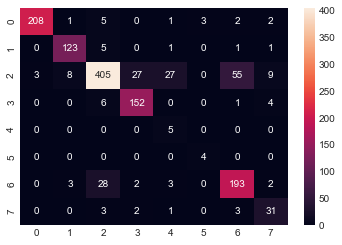

In [180]:
#confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='g')

## Applying our Model

The following code, serves to illustrate and assess how our model will work in a production environment, where the product is going to be user-facing. 

In [411]:
def normalize_doc(doc):
    doc=re.sub(r'[^a-zA-Z\s]', '', doc) 
    doc=doc.lower() 
    doc=doc.strip() 
    tokens=wpt.tokenize(doc)
    filtered_tokens=[token for token in tokens if token not in stop_words]
    doc=' '.join(filtered_tokens)
    return doc

In [364]:
sample_text = ['SL2 self checkout printer not functioning']

In [320]:
#add new clean text to dataframe
normalize_corpus=np.vectorize(normalize_doc) #create a vectorized object for our normalization pipeline
norm_text=normalize_corpus(sample_text) #clean and normalize the ticket

In [321]:
norm_text

array(['zebra printer getting data hardware issue lines chec'],
      dtype='<U52')

## Final Step - Text Transformation

In [322]:
with open ('final_model.pickle','rb') as f:#rb, read-byte
    final_model=pickle.load(f)

In [323]:
#access the steps of our finalized model to apply to a single ticket
vect=final_model.named_steps['tfidf']
clf=final_model.named_steps['clf']

In [324]:
trans_text=vect.transform(norm_text).toarray() #apply text extraction using TFIDF 
print(clf.predict(trans_text)) #apply logistic regression model classifier to text 

[7]


As we can see, the model output a numeric label corresponding to the class or team that the inputted ticket belongs to. It accurately predicted the team, which is the IT Service Desk Team. We can take this a step further and show the probability predictions of belonging to the classes we have. 

In [373]:
prob_classes=(clf.predict_proba(trans_text))
prob_classes=prob_classes[0][:]
prob_classes_num = ["{:.2%}".format(prob) for prob in prob_classes]
prob_classes_num

['0.06%', '0.04%', '16.78%', '5.16%', '0.05%', '0.03%', '1.59%', '76.28%']

We see the probablities of the ticket belonging to each class. The highest probability is what is used in the prediction. Probabilities will serve to be helpful in the case that a ticket's classification is ambiguous. 

# Logic for Prediction Output

Here we will build out functions and logic for displaying output to the user when using the web application. 

In [412]:
normalize_corpus=np.vectorize(normalize_doc) #create a vectorized object for our normalization pipeline
norm_text=normalize_corpus(sample_text) #clean and normalize the ticket

vect=final_model.named_steps['tfidf']
clf=final_model.named_steps['clf']

trans_text=vect.transform(norm_text).toarray()
prediction=clf.predict(trans_text)
probabilities=(clf.predict_proba(trans_text))

In [413]:
def output_prediction(label_prediction):
    #identify the class prediction 
    if label_prediction==0:
        owner='EAM & MRO Inventory Support'
    elif label_prediction==1:
        owner='HRIS Team'
    elif label_prediction==2: 
        owner='IT Service Desk Team'
    elif label_prediction==3:
        owner='Network Team'
    elif label_prediction==4:
        owner='OTM Support'
    elif label_prediction==5:
        owner='Planning Support'
    elif label_prediction==6:
        owner='System Admin Team'
    else:
        owner='WMS Team'
    return print(owner)

In [414]:
output_prediction(prediction)

WMS Team


In [405]:
def output_probabilities(array_prob):
    prob_classes=array_prob[0][:]
    prob_classes_num = ["{:.2%}".format(prob) for prob in prob_classes]
    
    classes = ['EAM & MRO Inventory Support', 'HRIS Team', 'IT Service Desk Team', 'Network Team', 'OTM Support', 
          'Planning Support', 'System Admin Team', 'WMS Team']
    ownerDict = dict(zip(classes, prob_classes_num))
    ownerDf = pd.DataFrame(ownerDict.items(), columns=['Owner', 'Probability'])
    
    return(ownerDf)

In [415]:
output_probabilities(probabilities)

,Owner,Probability
0,EAM & MRO Inventory Support,0.06%
1,HRIS Team,0.04%
2,IT Service Desk Team,16.78%
3,Network Team,5.16%
4,OTM Support,0.05%
5,Planning Support,0.03%
6,System Admin Team,1.59%
7,WMS Team,76.28%
